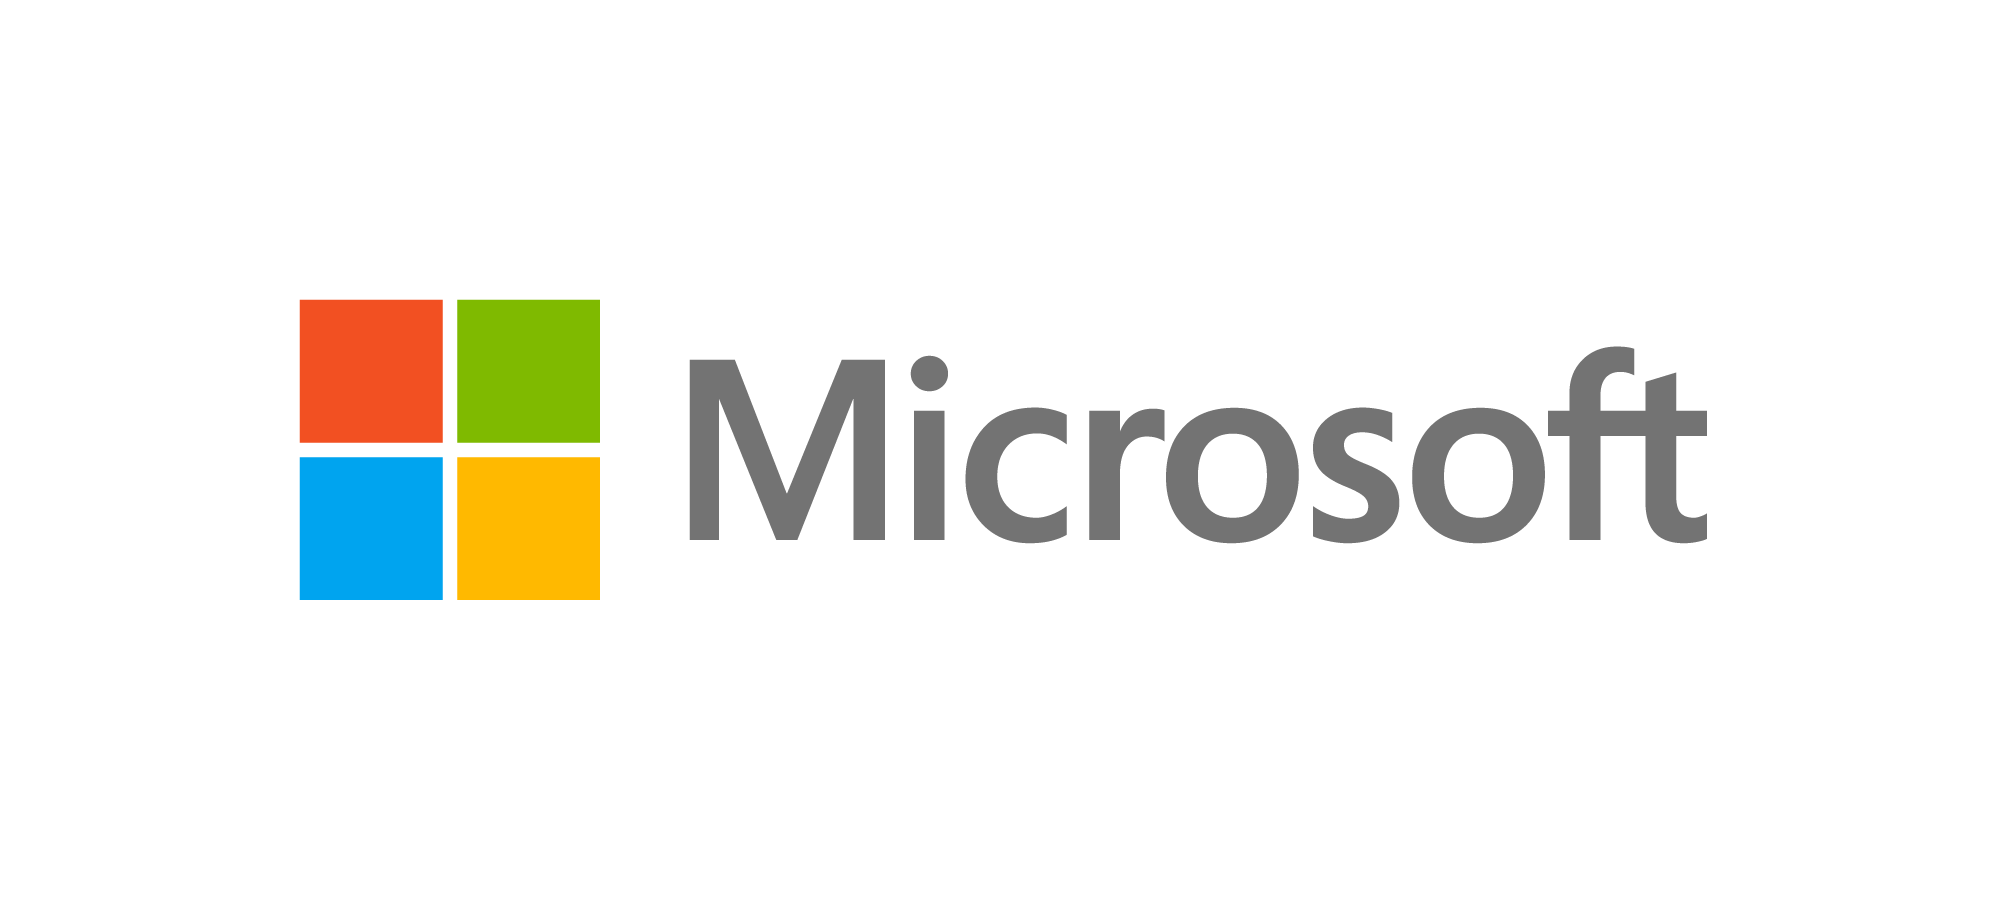

# Microsoft Movie Studios Analysis

**Authors:** Dermot O'Brien, Ziyuan Wang
***

## Overview

We have been tasked with providing the head of "Microsoft Movie Studios" three actionable insights that they can use to decide what kinds of films to make. To make these reccommendations, we must first gather movie data from reputable sources, clean the data properly, and analyze and vizualize our findings simply and effectively.

## Business Problem

Microsoft Movie Studios is a relatively new division that is looking to compete with the best movie makers in the business. To do this, they will first need to have a better understanding of their competitors successes and failures, the trends related to the kinds of movies that are successful, the types of movies that have high production costs and gross profits, etc. In this analysis, we hope to provide a clearer picture of the industry and target an area of focus for Microsoft Movie Studios to take advantage of. 

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

To analyze the movie industry as a whole, we took data from the following sources:
- Box Office Mojo
- Rotten Tomatoes
- The Movie Database (TMDB)
- The Numbers
- Internet Movie Database (IMDB)

These datasets come from reputable sources in the movie industry and include insightful data points like movie ratings, genres, production budgets, gross profits, etc.

In [55]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from collections import defaultdict
from IPython.display import Image
%matplotlib inline

# Create a connection to IMDB Database
conn = sqlite3.connect('./zippedData/im.db')

# JN Display Options
pd.options.display.max_rows = 1000

In [56]:
# Create dataframes from the files

# Box Office Mojo
bom_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

# Rotten Tomatoes Movies
rt_movie_df = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', delimiter='\t')

# Rotten Tomatoes Reviews
rt_reviews_df = pd.read_csv('./zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')

# The Numbers Movie Budgets
tn_movies_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

# The Movie Data Base Movies
tmdb_movies_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz') # genre ids?

# IMDB Database (Schema)
imdb_schema = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)

## Data Preparation

Each dataset had unique properties and needed to be prepared depending on it's individual needs and the type of analysis we planned to perform.

For the Rotten Tomatoes data, we decided to merge the movies and reviews tables into a new dataframe called rt_full_df. Using an inner join, this new dataframe includes only movies from both tables, and allowes us to analyze ratings of different movie genres.

For IMDB database, we creted a new dataframe by inner joining the movie_basics and movie_ratings tables.

For TMDB dataset, we needed to create a column called "main genre" that listed the primary genre of a movie given its ID. To do this we parsed the list of genre id's and only returned the primary id. We then created a dictionary that worked as a key to identify the name of a genre given the genre id, and then returned that name as a string in the "main genre" column.

For TN dataset, we needed to first manipulate the monetary values from strings to integers. We then merged this table with the imdb table movie_basics in order to see each movies genre. We then merged this new table with imdb table movie_ratings in order to see the average rating and corresponding number of votes per movie. We again parsed the genre's to see only the primary genre, and also converted the monetary values from dollars to million dollars. 

## Analysis

### Genre Analysis

##### Write about analysis here

##### Merge the Rotten Tomatoes Dataframes

In [57]:
# Merge the dataframes using an inner join
rt_full_df = rt_movie_df.merge(rt_reviews_df, how='inner', on='id')
rt_full_df.head(3)

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"


##### Best Genre's according to top critics "fresh" ratings

The "Fresh" column is used by a critic to indicate, on a binary scale, whether the movie was good (fresh) or bad (rotten). To use this data for analysis, we took the sum of the "fresh" ratings for a given movie divided by the total ratings in the fresh column, the sum of "fresh" and "rotten" ratings, to derive a value we called "Fresh Rating" for each movie. Using this new value, we took the average "Fresh Rating" per genre to see which genres were most enjoyed by rotten tomato users.

In [58]:
# Create a dictionary with k = movie id and v = fresh/total ratio of all "fresh" ratings by critics per movie
movie_fresh_dict = {} 
for movie_id in rt_full_df.groupby(by='id').groups:
    count = rt_full_df.groupby(by='id').get_group(movie_id)['fresh'].value_counts().values.tolist()
    total_count = sum(count)
    if total_count >= 100:
        try:
            ratio = round(count[0] / (count[0] + count[1]), 2)
        except:
            ratio = 1
    else:
        continue
    
    movie_fresh_dict[movie_id] = ratio
#movie_fresh_dict

In [59]:
# Filter out rows that have less than 100 fresh ratings, to keep only signficant ratings
genre_clean = rt_full_df.groupby(by='id').count()
genre_clean = genre_clean.loc[genre_clean['fresh'] > 100]
genre_index_100 = list(genre_clean.index)
genre_df = rt_full_df.loc[rt_full_df['id'].isin(genre_index_100)]

# Create a dictionary where k = movie id and v = genre
genre_dict = dict(zip(genre_df.id, genre_df.genre))
#genre_dict

In [60]:
# Create a dictionary where k = movie id and v = list that includes the fresh rating and genre
genre_rating_dict = {}

for key in (movie_fresh_dict.keys() | genre_dict.keys()):
    if key in movie_fresh_dict: 
        genre_rating_dict.setdefault(key, []).append(movie_fresh_dict[key])
    if key in genre_dict: 
        genre_rating_dict.setdefault(key, []).append(genre_dict[key])
#genre_rating_dict

In [61]:
# Create a dataframe that includes movie id (as index), Fresh Ratio, Genre
genre_rating_df = pd.DataFrame.from_dict(genre_rating_dict, orient='index', columns=['Fresh Ratio', 'Genre']).sort_values(by='Fresh Ratio', ascending=False)
genre_rating_df['Main Genre'] = genre_rating_df['Genre'].str.split("|").str[0]
#genre_rating_df

In [62]:
# Group dataframe by Genre and find the average fresh ratio for each genre
genre_rating_df = genre_rating_df.groupby(by='Main Genre').mean().sort_values(by='Fresh Ratio', ascending=False).reset_index()

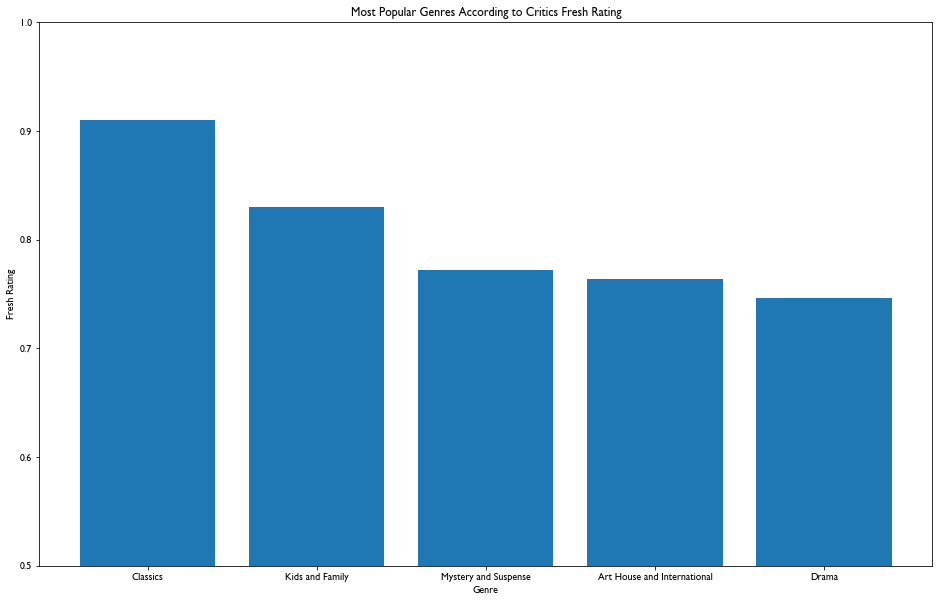

In [63]:
# Create a bar chart
genre_x = genre_rating_df['Main Genre'].head()
rating_y = genre_rating_df['Fresh Ratio'].head()

fig, ax = plt.subplots(figsize = (16,10))

ax.set_ylim(.5, 1)
ax.bar(genre_x, rating_y)
ax.set_xlabel('Genre')
ax.set_ylabel('Fresh Rating')
ax.set_title('Most Popular Genres According to Critics Fresh Rating');

According to rotten tomatoes users, the top 5 genres according to the fresh scale are Classics, Kids and Family, Mystery and Suspense, Arthouse, and Drama.

##### Best genre according to IMDB

In this analysis, we wanted to see what the highest rated genres were in IMDB's database. To prepare the data, we inner joined the movie_basics and movie_ratings tables on movie_id and only looked at movies with votes greater than 10,000 (to keep the rating value significant). See our preparation and analysis below:

In [5]:
# Create a dataframe, limit min numvotes to get significant ratings
imdb_genre_df = pd.read_sql("""
SELECT *
FROM
    movie_basics as mb
    INNER JOIN movie_ratings as mr
        USING(movie_id)
WHERE numvotes > 10000
""", conn)

In [6]:
# Extract the primary genre from the list of genres per movie
imdb_genre_df['main_genre'] = imdb_genre_df['genres'].str.split(",").str[0]

In [7]:
# Group by genre and find the average rating per genre using median
imdb_pop_genre_df = imdb_genre_df.groupby(by='main_genre').mean().sort_values(by='averagerating', ascending=False).reset_index()

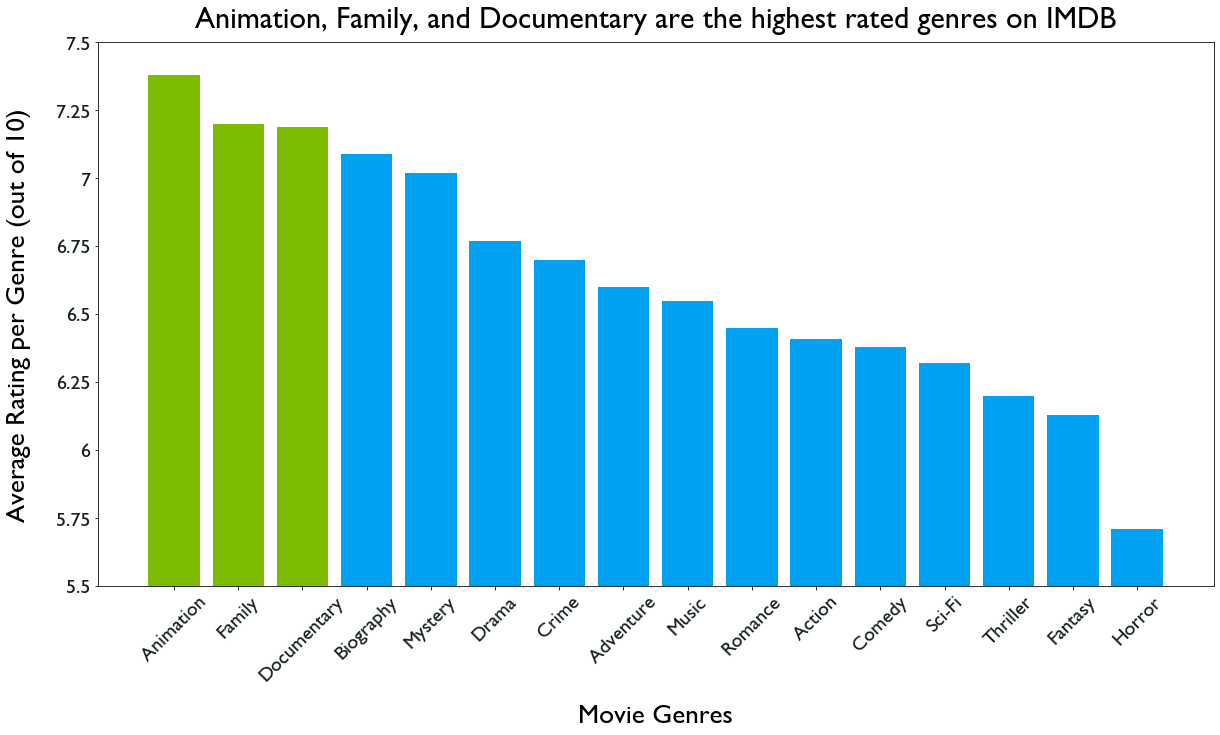

In [17]:
# Create variables for chart
imdb_genre_x = imdb_pop_genre_df['main_genre']
imdb_rating_y = round(imdb_pop_genre_df['averagerating'],2)
y_ticks = [5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5]
c = ['#7CBB00', '#7CBB00', '#7CBB00', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1', '#00A1F1']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))

bars = ax.bar(imdb_genre_x, imdb_rating_y, color=c)
ax.set_xlabel('Movie Genres', fontsize=27, labelpad=20)
ax.set_ylabel('Average Rating per Genre (out of 10)', fontsize=27, labelpad=25)
ax.set_title('Animation, Family, and Documentary are the highest rated genres on IMDB', fontsize=30, pad=15)
ax.set_ylim(5.5, 7.5, .5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=20, color='#152022')
ax.set_xticks(imdb_genre_x)
ax.set_xticklabels(imdb_genre_x, fontsize=20, rotation=45, color='#152022');
#for bar in bars:
#    yval = bar.get_height()
#    plt.text(bar.get_x(), yval + .015, yval, fontsize=15)

As shown, Documentary, Animation, Family are the highest rated genre's in IMDB's database. Note that we took the median rating per genre.

#### Best Genre according to TMDB ratings

#### write about analysis

In [18]:
# Create a dictionary with genreid and its corresponding genre type
tmdn_genreid = {28:"Action",
                12:"Adventure",
                16:"Animation",
                35:"Comedy",
                80:"Crime",
                99: "Documentary",
                18: "Drama",
                10751: "Family",
                14: "Fantasy",
                36: "History",
                27: "Horror",
                10402: "Music",
                9648:"Mystery",
                10749: "Romance",
                878: "Science Fiction",
                10770: "TV Movie",
                53: "Thriller",
                10752: "War",
                37: "Western"}

In [19]:
# Filter the dataframe with no empty content in genre_ids
tmdb_movies_df = tmdb_movies_df.loc[tmdb_movies_df['genre_ids'] != '[]']

In [20]:
#Obtain the primary genre id and get rid of "," and "[]"
tmdb_movies_df['genre1'] = tmdb_movies_df['genre_ids'].str.split(",").str[0]
tmdb_movies_df['genre1'] = tmdb_movies_df['genre1'].str.strip('[')
tmdb_movies_df['genre1'] = tmdb_movies_df['genre1'].str.strip(']')

In [21]:
#Convert the type of primary genre id from string to integer
tmdb_movies_df['genre1'] = tmdb_movies_df['genre1'].astype(int)

In [23]:
#Create a new column with genre type name with the dictionary created above and genre ids
tmdb_movies_df['genre1_name'] = tmdb_movies_df['genre1'].map(tmdn_genreid)

#tmdb_movies_df

In [25]:
# Create a copy for future use (multiple graphs)
tmdb_movies1_df = tmdb_movies_df.copy()

In [26]:
#Filter out rows with number of votes > 5000 and average rate not as zero
tmdb_movies11_df = tmdb_movies1_df.loc[(tmdb_movies_df['vote_count'] >= 5000) & (tmdb_movies1_df['vote_average'] != 0.0)]

In [28]:
#Caculate the average rating group by primary genre type in desc order
rate_for_each_genre = tmdb_movies11_df.groupby('genre1_name')['vote_average'].mean().sort_values(ascending=False)
#rate_for_each_genre

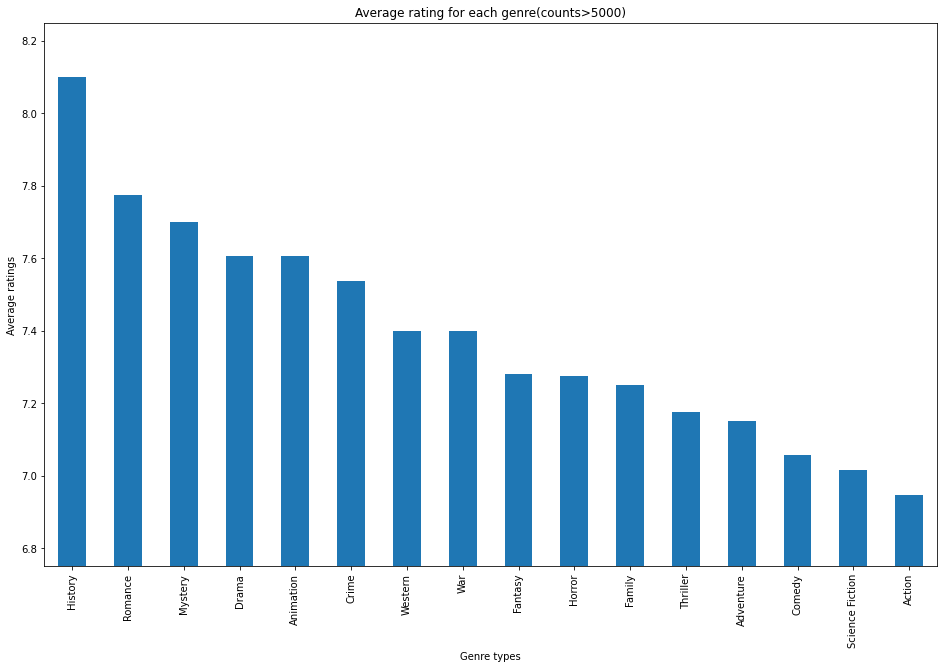

In [31]:
#Plot a bar chart with data above
rate_for_each_genre.plot(kind = 'bar', title = 'Average rating for each genre(counts>5000)', ylim=(6.75, 8.25), figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average ratings");


In [32]:
#Filter out rows with number of votes > 2000 and average rate not as zero
tmdb_movies111_df = tmdb_movies1_df.loc[(tmdb_movies1_df['vote_count'] >= 2000) & (tmdb_movies1_df['vote_average'] != 0.0)]

In [34]:
#Caculate the average rating group by primary genre type in desc order
rate_for_each_genre1 = tmdb_movies111_df.groupby('genre1_name')['vote_average'].mean().sort_values(ascending=False)
#rate_for_each_genre1

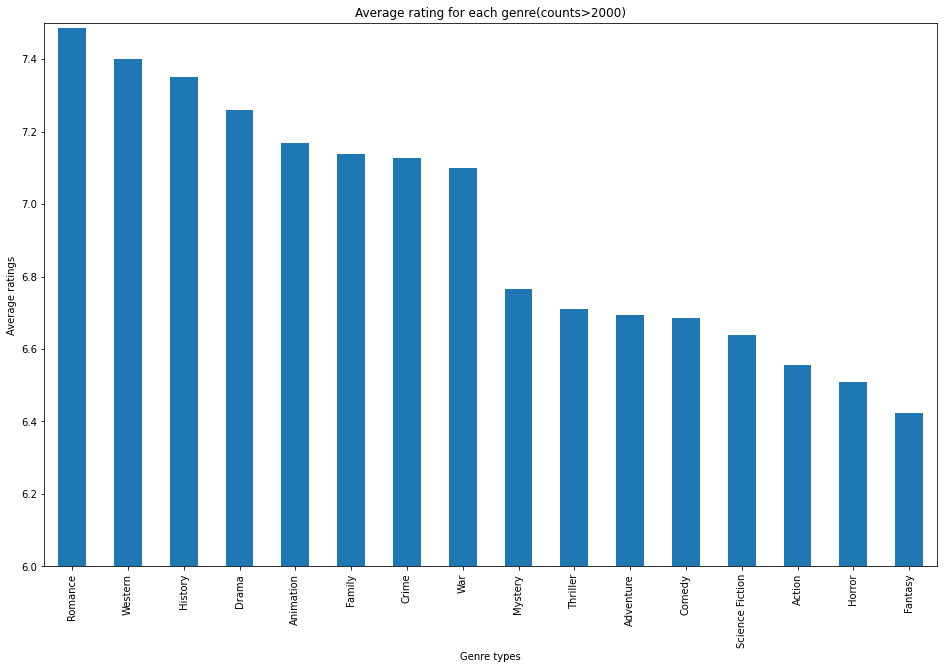

In [36]:
#Plot a bar chart with data above
rate_for_each_genre1.plot(kind = 'bar', title = 'Average rating for each genre(counts>2000)', ylim=(6, 7.5), figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average ratings");


Write about graph above

In [37]:
#Filter out rows with number of votes > 1000 and average rate not as zero
tmdb_movies1111_df = tmdb_movies1_df.loc[(tmdb_movies1_df['vote_count'] >= 1000) & (tmdb_movies1_df['vote_average'] != 0.0)]

In [39]:
#Caculate the average rating group by primary genre type in desc order
rate_for_each_genre11 = tmdb_movies1111_df.groupby('genre1_name')['vote_average'].mean().sort_values(ascending=False)
#rate_for_each_genre11

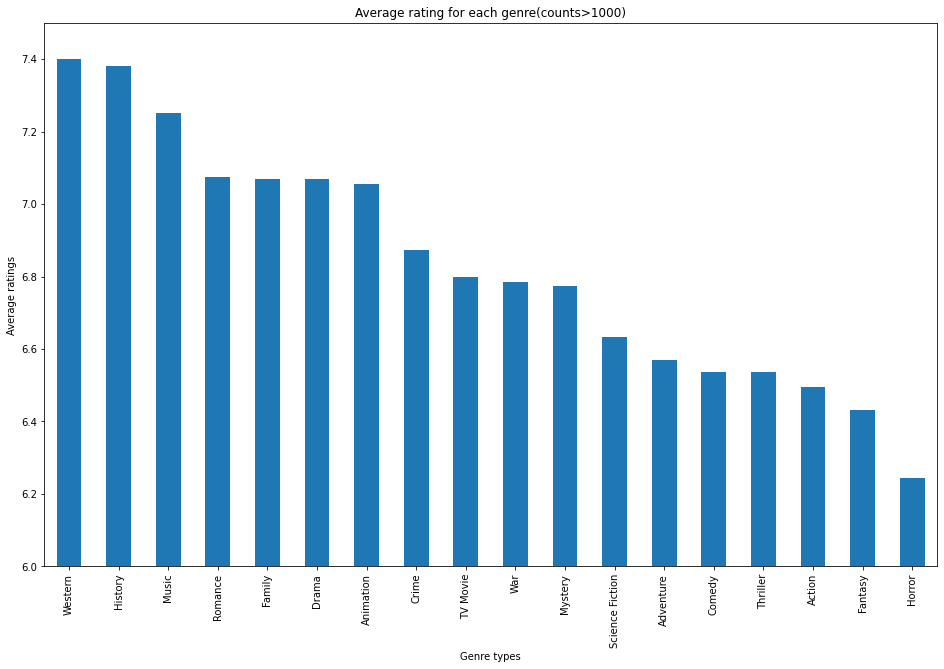

In [41]:
#Plot a bar chart with data above
rate_for_each_genre11.plot(kind = 'bar', title = 'Average rating for each genre(counts>1000)', ylim=(6, 7.5), figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average ratings");


Write about graph above

## TN Analysis

### write about analysis

In [64]:
# the the steps below, since the type of cells for budget and gross are all strings, we want to convert them into integers.
# these just some processes to get rid of '$' and ","
tn_movies_df['production_budget'] = tn_movies_df['production_budget'].str.strip('$')

tn_movies_df['production_budget'] = tn_movies_df['production_budget'].str.replace(',','')

tn_movies_df['production_budget'] = tn_movies_df['production_budget'].astype(int)

tn_movies_df['domestic_gross'] = tn_movies_df['domestic_gross'].str.strip('$')

tn_movies_df['domestic_gross'] = tn_movies_df['domestic_gross'].str.replace(',','')

tn_movies_df['domestic_gross'] = tn_movies_df['domestic_gross'].astype(int)

tn_movies_df['worldwide_gross'] = tn_movies_df['worldwide_gross'].str.strip('$')

tn_movies_df['worldwide_gross'] = tn_movies_df['worldwide_gross'].str.replace(',','')

tn_movies_df['worldwide_gross'] = tn_movies_df['worldwide_gross'].astype('int64')

In [65]:
# Create a copy of tn_movies for further uses
tn1 = tn_movies_df.copy()

In [66]:
#Create a dataframe with movie ids, movie titles and genres from movies_basics table 
im1_df = pd.read_sql("""
SELECT 
       movie_id AS movie_id,
       original_title AS original_title,
       runtime_minutes AS runtime_minutes,
       genres AS genres
FROM movie_basics


""", conn)
im1_df

,movie_id,original_title,runtime_minutes,genres
0,tt0063540,Sunghursh,175.0,"Action,Crime,Drama"
1,tt0066787,Ashad Ka Ek Din,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,122.0,Drama
3,tt0069204,Sabse Bada Sukh,NaN,"Comedy,Drama"
4,tt0100275,La Telenovela Errante,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,NaN,Documentary
146141,tt9916706,Dankyavar Danka,NaN,Comedy
146142,tt9916730,6 Gunn,116.0,None


In [67]:
# Create a dataframe called im2_df with all the information from movies_ratings table 
im2_df = pd.read_sql("""
SELECT *
FROM movie_ratings

""", conn)
#im2_df

In [68]:
# Merge the dataframes of tn and im1 on moive titles using an inner join
Merged_df = tn1.merge(im1_df,
          left_on='movie',
          right_on='original_title',
          how='inner')
#Merged_df

In [69]:
## Merge the dataframes of previous merged dataframe and im2 on moive ids using an inner join
TB_IM_Merged = Merged_df.merge(im2_df,
          left_on='movie_id',
          right_on='movie_id',
          how='inner')
#TB_IM_Merged

In [70]:
#the numbers for budget and gross are too huge
#just trying to convert the units from dollars to million dollars to make it easier to look
TB_IM_Merged['production_budget(million)'] = TB_IM_Merged['production_budget']/ 1000000

TB_IM_Merged['domestic_gross(million)'] = TB_IM_Merged['domestic_gross']/ 1000000

TB_IM_Merged['worldwide_gross(million)'] = TB_IM_Merged['worldwide_gross']/ 1000000

In [71]:
#creating a column with the calculated profit in million dollars
TB_IM_Merged['profit(million)'] = TB_IM_Merged['worldwide_gross(million)'] + TB_IM_Merged['domestic_gross(million)'] - TB_IM_Merged['production_budget(million)']

In [72]:
# Found out the primary genre since we only want to focus on the primary genre
TB_IM_Merged['genre1'] = TB_IM_Merged['genres'].str.split(",").str[0]

In [74]:
TB_IM1 = TB_IM_Merged.copy()

In [75]:
#Filter out rows with ratings > 6.0, number of votes > 10000, profit more than 400 million
TB_IM2 = TB_IM1.loc[(TB_IM1['averagerating'] > 6) & (TB_IM1['numvotes'] > 10000) & (TB_IM1['profit(million)'] > 400)]
#TB_IM2

In [76]:
#make a new dataframe with information that will be used in data analysis
TB_IM_Final = TB_IM2[['movie', 'genre1','production_budget(million)','domestic_gross(million)','worldwide_gross(million)','profit(million)','averagerating','numvotes']]
#TB_IM_Final

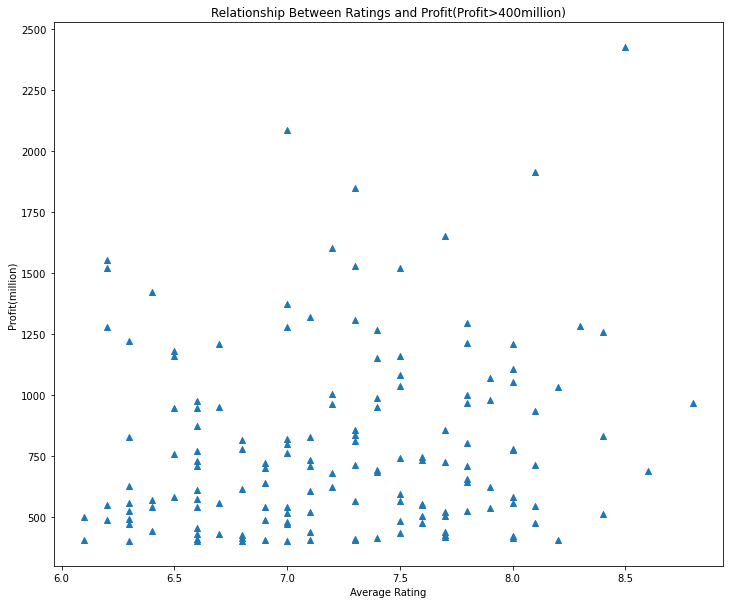

In [77]:
#Make a scatter plt with rating as x-axis and profit as y-axis
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(x=TB_IM_Final['averagerating'], y=TB_IM_Final['profit(million)'],
           marker='^')

ax.set_xlabel('Average Rating')
ax.set_ylabel('Profit(million)')
ax.set_title('Relationship Between Ratings and Profit(Profit>400million)');

In [61]:
#Caculate the average profit group by primary genre type in desc order
profit_for_each_genre = TB_IM_Final.groupby('genre1')['profit(million)'].mean().sort_values(ascending=False)
#profit_for_each_genre

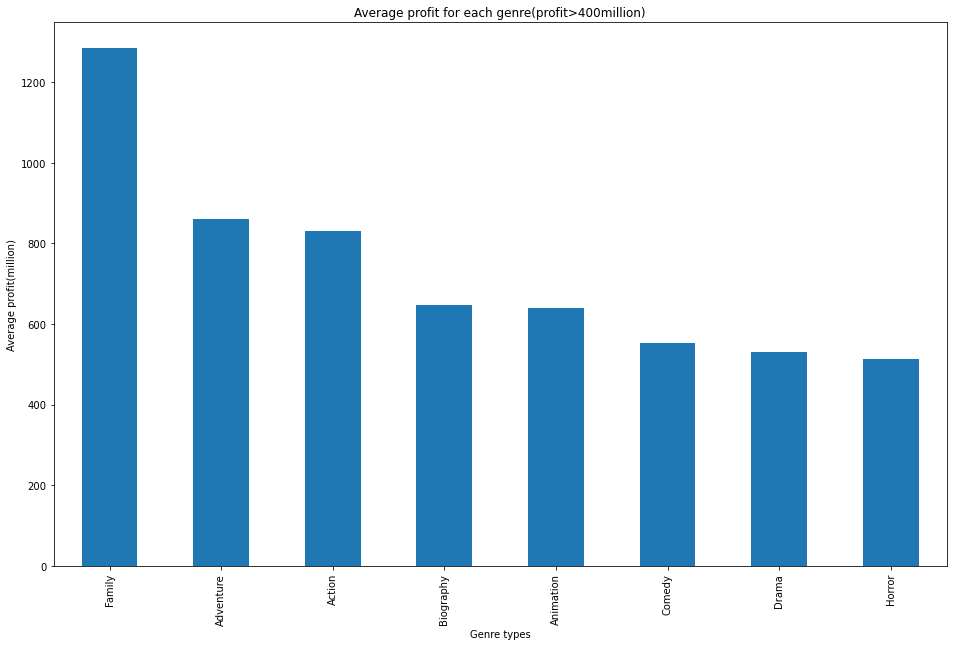

In [63]:
#Plot a bar chart with data above
profit_for_each_genre.plot(kind = 'bar', title = 'Average profit for each genre(profit>400million)', figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average profit(million)");

In [64]:
#Filter out rows with ratings > 6.0, number of votes > 10000, profit more than 200 million
TB_IM22 = TB_IM1.loc[(TB_IM1['averagerating'] > 6) & (TB_IM1['numvotes'] > 10000) & (TB_IM1['profit(million)'] > 200)]
#TB_IM22

In [65]:
#make a new dataframe with information that will be used in data analysis
TB_IM_Final22 = TB_IM22[['movie', 'genre1','production_budget(million)','domestic_gross(million)','worldwide_gross(million)','profit(million)','averagerating','numvotes']]
#TB_IM_Final22

In [66]:
#Caculate the average profit group by primary genre type in desc order
profit_for_each_genre2 = TB_IM_Final22.groupby('genre1')['profit(million)'].mean().sort_values(ascending=False)
#profit_for_each_genre2

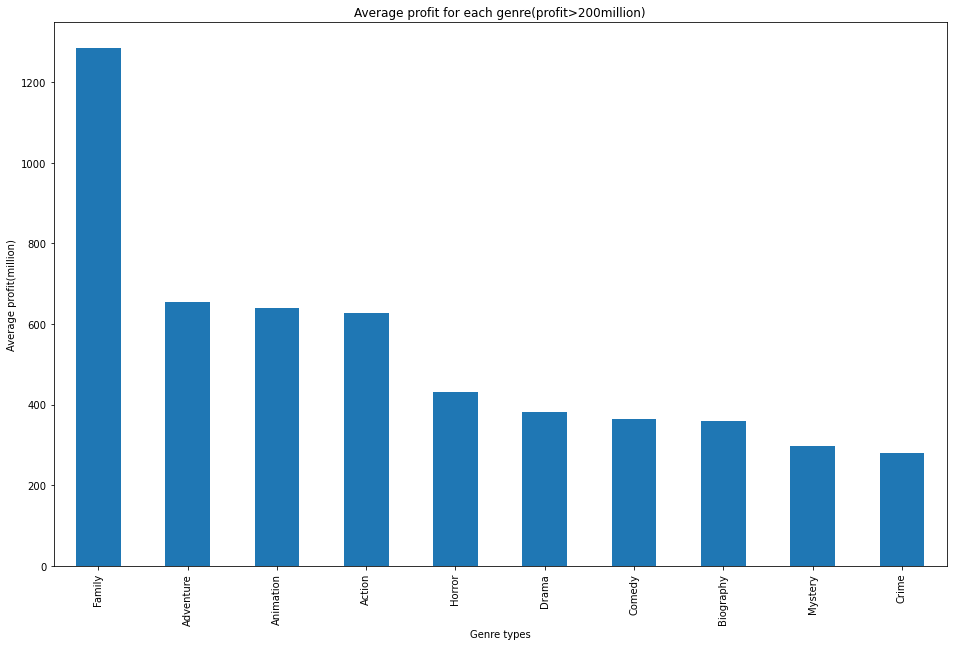

In [69]:
#Plot a bar chart with data above
profit_for_each_genre2.plot(kind = 'bar', title = 'Average profit for each genre(profit>200million)', figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average profit(million)");

In [70]:
#Filter out rows with ratings > 6.0, number of votes > 10000, profit more than 100 million
TB_IM222 = TB_IM1.loc[(TB_IM1['averagerating'] > 6) & (TB_IM1['numvotes'] > 10000) & (TB_IM1['profit(million)'] > 100)]
#TB_IM222

In [78]:
#make a new dataframe with information that will be used in data analysis
TB_IM_Final222 = TB_IM222[['movie', 'genre1','production_budget(million)','domestic_gross(million)','worldwide_gross(million)','profit(million)','averagerating','numvotes']]
#TB_IM_Final222

In [80]:
#Caculate the average profit group by primary genre type in desc order
profit_for_each_genre222 = TB_IM_Final222.groupby('genre1')['profit(million)'].mean().sort_values(ascending=False)
#profit_for_each_genre222

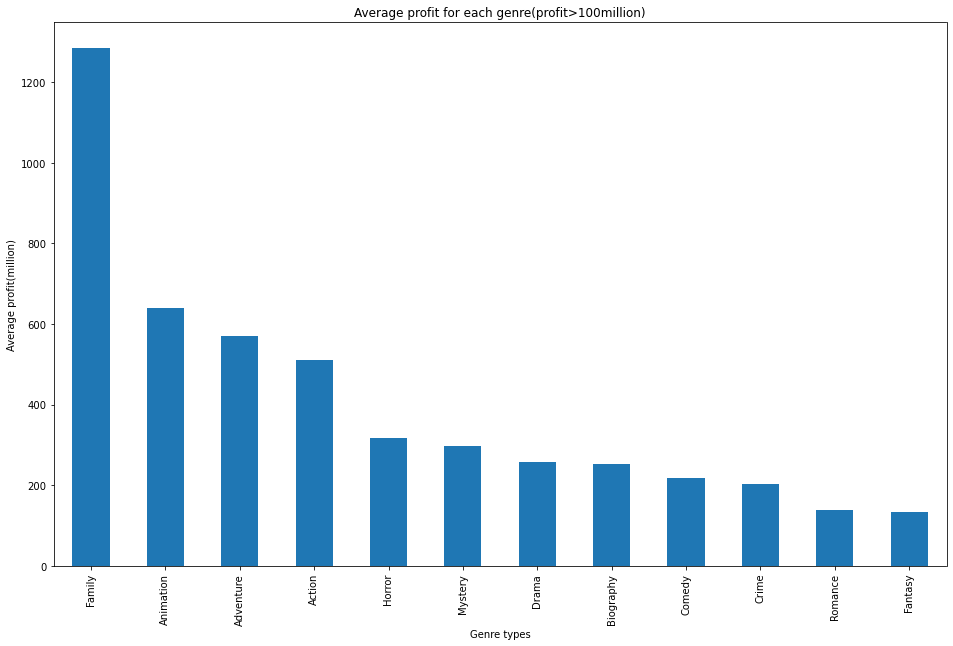

In [82]:
#Plot a bar chart with data above
profit_for_each_genre222.plot(kind = 'bar', title = 'Average profit for each genre(profit>100million)', figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average profit(million)");

In [83]:
#Filter out rows with ratings > 6.0, number of votes > 10000, budget more than 10 million
TB_IM3 = TB_IM1.loc[(TB_IM1['averagerating'] > 6) & (TB_IM1['numvotes'] > 10000) & (TB_IM1['production_budget(million)'] > 10)]
#TB_IM3

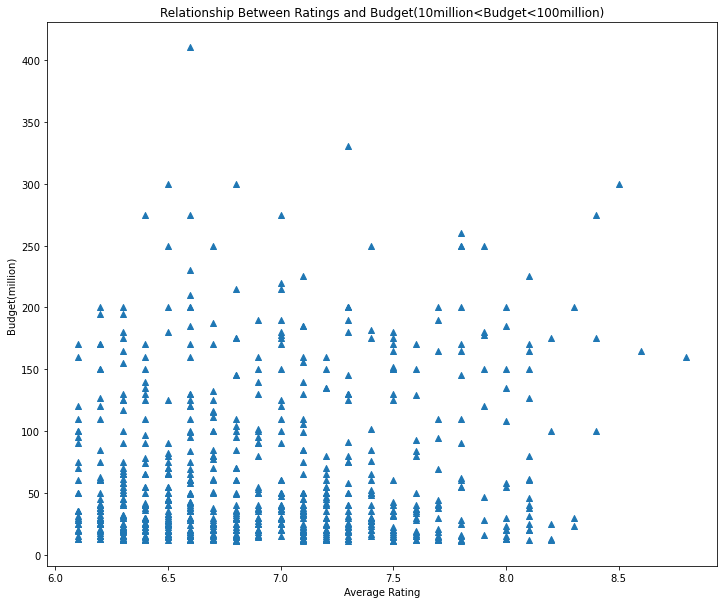

In [84]:
#Make a scatter plt with rating as x-axis and budget as y-axis
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(x=TB_IM3['averagerating'], y=TB_IM3['production_budget(million)'],
           marker='^')

ax.set_xlabel('Average Rating')
ax.set_ylabel('Budget(million)')
ax.set_title('Relationship Between Ratings and Budget(10million<Budget<100million)');

In [85]:
#Caculate the average budget group by primary genre type in desc order
budget_for_each_genre = TB_IM3.groupby('genre1')['production_budget(million)'].mean().sort_values(ascending=False)
#budget_for_each_genre

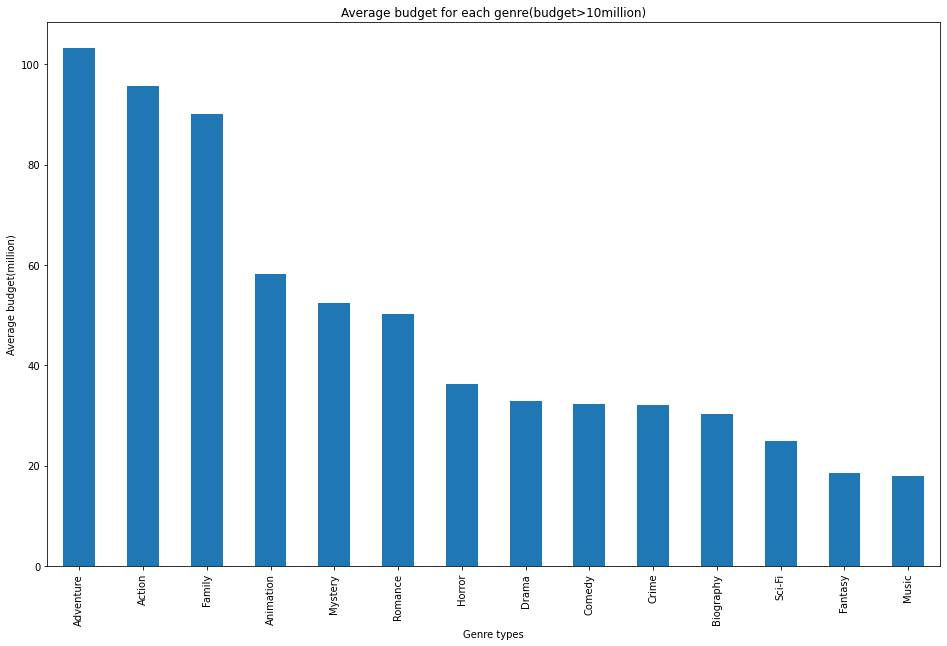

In [87]:
#Plot a bar chart with data above
budget_for_each_genre.plot(kind = 'bar', title = 'Average budget for each genre(budget>10million)', figsize=(16,10))


plt.xlabel("Genre types")
plt.ylabel("Average budget(million)");

In [88]:
#Filter out rows with ratings > 6.0, number of votes > 10000, budget more than 10 million, and profit more than 400million
TB_IM4 = TB_IM1.loc[(TB_IM1['averagerating'] > 6) & (TB_IM1['numvotes'] > 10000) & (TB_IM1['production_budget(million)'] > 10) & (TB_IM1['profit(million)'] > 400)]
#TB_IM4

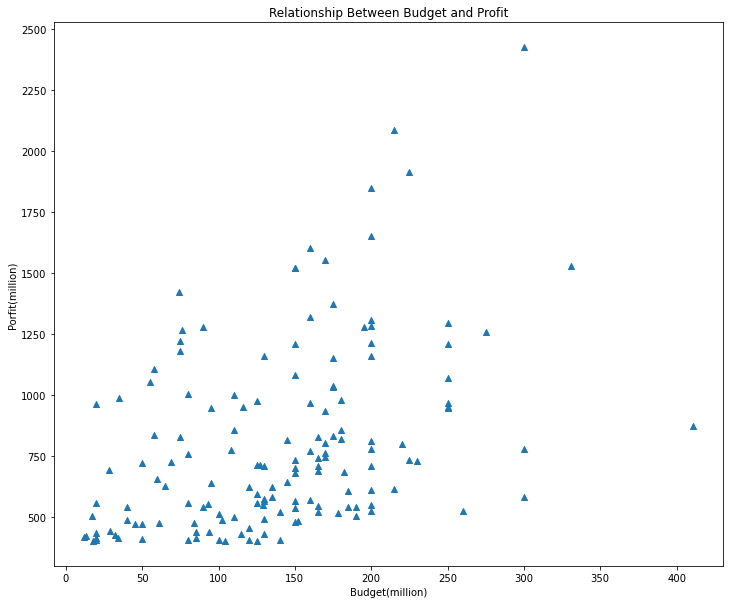

In [89]:
#Make a scatter plt with budget as x-axis and profit as y-axis
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(x=TB_IM4['production_budget(million)'], y=TB_IM4['profit(million)'],
           marker='^')

ax.set_xlabel('Budget(million)')
ax.set_ylabel('Porfit(million)')
ax.set_title('Relationship Between Budget and Profit');

### IMDB Data Inspection, Preparation, and Analysis

##### Best Runtimes according to IMDB ratings
Using the IMDB database, we wanted to know what the typical runtimes are for movies with high ratings (defined by a movie having an average rating greater than or equal to 7). To prepare the data, we inner joined the movie_basics and movie_ratings tables on movie_id. We then set two conditions: that the number of votes is greater than 10,000 and that the average rating is greater than or equal to a 7. We distinguished that only ratings with greater than 10,000 votes were significant enough to display. See our preparation and analysis below:

In [19]:
# Create a dataframe to analysze runtimes
runtime_df = pd.read_sql("""
SELECT *
FROM
    movie_basics as mb
    INNER JOIN movie_ratings as mr
        USING(movie_id)
WHERE numvotes > 10000 and averagerating >= 7.0 -- chose 10,000 so the ratings were significant, less significant the smaller the vote count
ORDER BY averagerating ASC
""", conn)

In [20]:
# Drop movies that aggregate mutiple parts. The movies below were either docuseries with multiple episodes aggregated 
# or had Part1/Part2 combined into one runtime
runtime_df.loc[runtime_df['runtime_minutes'] > 200]
runtime_df.drop([174, 904, 972], inplace=True)

In [21]:
# Check the min and max runtimes in order to create a range for the histogram bins
runtime_df['runtime_minutes'].describe()

count    974.000000
mean     118.239220
std       21.534772
min       45.000000
25%      102.000000
50%      116.000000
75%      132.000000
max      196.000000
Name: runtime_minutes, dtype: float64

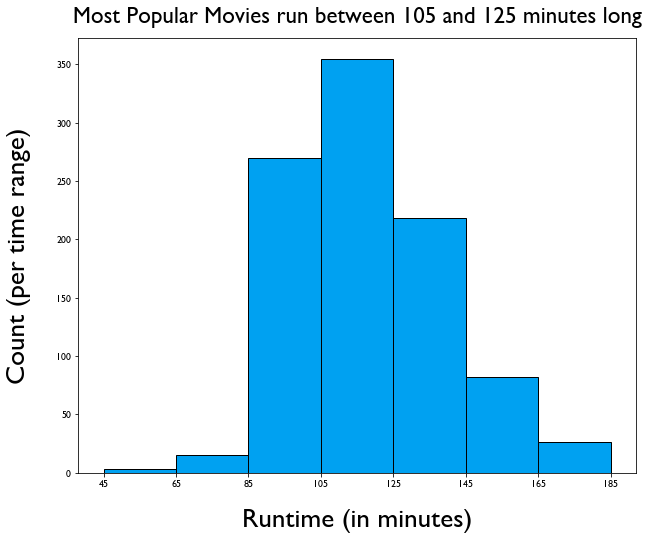

In [43]:
# Create variable for chart
x = runtime_df['runtime_minutes']
bin_names = ["45-65","65-85", "85-105", "105-125", "125-145", "145-165", "165-195"]
c = ['#00A1F1']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create a histogram to show frequencies of popular movie's runtimes
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(x, bins=range(45, 195, 20), edgecolor='black', color=c)
ax.set_xlabel('Runtime (in minutes)', fontsize=27, labelpad=20)
ax.set_ylabel('Count (per time range)', fontsize=27, labelpad=25)
ax.set_title("Most Popular Movies run between 105 and 125 minutes long", fontsize=23, pad=15)
ax.set_xticks(range(45, 195, 20));
#ax.set_xticklabels(x, fontsize=20, rotation=45, color='#152022')
#ax.set_xticklabels(bin_names, rotation=45);

As shown above, the most frequent length of a popular movie fall between 105 and 125 minutes. 

#### New analysis

In [46]:
imdb_schema = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)
imdb_schema

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [88]:
imdb_directors = pd.read_sql("""
SELECT DISTINCT movie_id, person_id
FROM directors
""", conn)
imdb_directors

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0878654,nm0089502
4,tt0878654,nm2291498
...,...,...
163530,tt8999974,nm10122357
163531,tt9001390,nm6711477
163532,tt9001494,nm10123242
163533,tt9001494,nm10123248


In [78]:
imdb_persons = pd.read_sql("""
SELECT *
FROM persons
""", conn)
imdb_persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [ ]:
TB_IM_Merged = Merged_df.merge(im2_df,
          left_on='movie_id',
          right_on='movie_id',
          how='inner')
TB_IM_Merged

In [84]:
imdb_directors

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [89]:
directors_df = TB_IM_Merged.merge(imdb_directors, on='movie_id', how='inner')
directors_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,averagerating,numvotes,production_budget(million),domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,410.6000,241.063875,1045.663875,876.127750,Action,nm0551128
1,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,350.0000,42.762350,149.762350,-157.475300,Action,nm1334526
2,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,330.6000,459.005868,1403.013963,1531.419831,Action,nm0923736
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,300.0000,678.815482,2048.134200,2426.949682,Action,nm0751577
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,300.0000,678.815482,2048.134200,2426.949682,Action,nm0751648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,68,"Jul 6, 2001",Cure,10000,94596,94596,tt1872026,Cure,93.0,Drama,4.9,11,0.0100,0.094596,0.094596,0.179192,Drama,nm0948107
2922,73,"Jan 13, 2012",Newlyweds,9000,4584,4584,tt1880418,Newlyweds,95.0,"Comedy,Drama",6.4,1436,0.0090,0.004584,0.004584,0.000168,Comedy,nm0122653
2923,78,"Dec 31, 2018",Red 11,7000,0,0,tt7837402,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,0.0070,0.000000,0.000000,-0.007000,Horror,nm0001675
2924,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,tt2107644,A Plague So Pleasant,76.0,"Drama,Horror,Thriller",5.4,72,0.0014,0.000000,0.000000,-0.001400,Drama,nm4766951


In [90]:
directors_name_df = directors_df.merge(imdb_persons, on="person_id", how="inner")
directors_name_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,...,production_budget(million),domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id,primary_name,birth_year,death_year,primary_profession
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",...,410.6000,241.063875,1045.663875,876.127750,Action,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer"
1,45,"Dec 19, 2018",Mary Poppins Returns,130000000,171958438,341528518,tt5028340,Mary Poppins Returns,130.0,"Comedy,Family,Fantasy",...,130.0000,171.958438,341.528518,383.486956,Comedy,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer"
2,77,"Dec 25, 2014",Into the Woods,56200000,128002372,213116401,tt2180411,Into the Woods,125.0,"Adventure,Comedy,Drama",...,56.2000,128.002372,213.116401,284.918773,Adventure,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer"
3,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",...,350.0000,42.762350,149.762350,-157.475300,Action,nm1334526,Simon Kinberg,1973.0,NaN,"producer,writer,director"
4,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",...,330.6000,459.005868,1403.013963,1531.419831,Action,nm0923736,Joss Whedon,1964.0,NaN,"writer,producer,director"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,tt3973612,Stories of Our Lives,60.0,Drama,...,0.0150,0.000000,0.000000,-0.015000,Drama,nm5874888,Jim Chuchu,NaN,NaN,"director,writer,editor"
2922,68,"Jul 6, 2001",Cure,10000,94596,94596,tt1872026,Cure,93.0,Drama,...,0.0100,0.094596,0.094596,0.179192,Drama,nm0948107,Bill Yip,NaN,NaN,"assistant_director,producer,actor"
2923,73,"Jan 13, 2012",Newlyweds,9000,4584,4584,tt1880418,Newlyweds,95.0,"Comedy,Drama",...,0.0090,0.004584,0.004584,0.000168,Comedy,nm0122653,Edward Burns,1968.0,NaN,"actor,writer,producer"
2924,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,tt2107644,A Plague So Pleasant,76.0,"Drama,Horror,Thriller",...,0.0014,0.000000,0.000000,-0.001400,Drama,nm4766951,Benjamin Roberds,NaN,NaN,"camera_department,director,writer"


In [94]:
directors_name_df['main_profession'] = directors_name_df['primary_profession'].str.split(",").str[0]


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,...,domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id,primary_name,birth_year,death_year,primary_profession,main_profession
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",...,241.063875,1045.663875,876.127750,Action,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",director
1,45,"Dec 19, 2018",Mary Poppins Returns,130000000,171958438,341528518,tt5028340,Mary Poppins Returns,130.0,"Comedy,Family,Fantasy",...,171.958438,341.528518,383.486956,Comedy,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",director
2,77,"Dec 25, 2014",Into the Woods,56200000,128002372,213116401,tt2180411,Into the Woods,125.0,"Adventure,Comedy,Drama",...,128.002372,213.116401,284.918773,Adventure,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",director
3,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",...,42.762350,149.762350,-157.475300,Action,nm1334526,Simon Kinberg,1973.0,NaN,"producer,writer,director",producer
4,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",...,459.005868,1403.013963,1531.419831,Action,nm0923736,Joss Whedon,1964.0,NaN,"writer,producer,director",writer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,tt3973612,Stories of Our Lives,60.0,Drama,...,0.000000,0.000000,-0.015000,Drama,nm5874888,Jim Chuchu,NaN,NaN,"director,writer,editor",director
2922,68,"Jul 6, 2001",Cure,10000,94596,94596,tt1872026,Cure,93.0,Drama,...,0.094596,0.094596,0.179192,Drama,nm0948107,Bill Yip,NaN,NaN,"assistant_director,producer,actor",assistant_director
2923,73,"Jan 13, 2012",Newlyweds,9000,4584,4584,tt1880418,Newlyweds,95.0,"Comedy,Drama",...,0.004584,0.004584,0.000168,Comedy,nm0122653,Edward Burns,1968.0,NaN,"actor,writer,producer",actor
2924,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,tt2107644,A Plague So Pleasant,76.0,"Drama,Horror,Thriller",...,0.000000,0.000000,-0.001400,Drama,nm4766951,Benjamin Roberds,NaN,NaN,"camera_department,director,writer",camera_department


In [ ]:
profit_for_each_genre2 = TB_IM_Final22.groupby('genre1')['profit(million)'].mean().sort_values(ascending=False)
profit_for_each_genre2

In [127]:
only_directors_df = directors_name_df.loc[directors_name_df['main_profession'] == 'director']
only_directors_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,...,domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id,primary_name,birth_year,death_year,primary_profession,main_profession
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",...,241.063875,1045.663875,876.127750,Action,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",director
1,45,"Dec 19, 2018",Mary Poppins Returns,130000000,171958438,341528518,tt5028340,Mary Poppins Returns,130.0,"Comedy,Family,Fantasy",...,171.958438,341.528518,383.486956,Comedy,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",director
2,77,"Dec 25, 2014",Into the Woods,56200000,128002372,213116401,tt2180411,Into the Woods,125.0,"Adventure,Comedy,Drama",...,128.002372,213.116401,284.918773,Adventure,nm0551128,Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",director
30,13,"Jul 2, 2013",The Lone Ranger,275000000,89302115,260002115,tt1210819,The Lone Ranger,150.0,"Action,Adventure,Western",...,89.302115,260.002115,74.304230,Action,nm0893659,Gore Verbinski,1964.0,NaN,"director,producer,writer",director
31,29,"Mar 4, 2011",Rango,135000000,123477607,245724600,tt1192628,Rango,107.0,"Adventure,Animation,Comedy",...,123.477607,245.724600,234.202207,Adventure,nm0893659,Gore Verbinski,1964.0,NaN,"director,producer,writer",director
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,48,"Jan 14, 2000",The Terrorist,25000,195043,195043,tt1737110,The Terrorist,86.0,"Romance,Thriller",...,0.195043,0.195043,0.365086,Romance,nm1297149,Jon Osman,NaN,NaN,"director,writer,producer",director
2914,49,"Sep 1, 2015",Exeter,25000,0,489792,tt2782686,Exeter,NaN,Horror,...,0.000000,0.489792,0.464792,Horror,nm4099523,Ann Tramonte,NaN,NaN,"director,actress,producer",director
2915,51,"Apr 21, 2015",Ten,25000,0,0,tt2309562,Ten,118.0,Drama,...,0.000000,0.000000,-0.025000,Drama,nm5188399,Craig Wyting,NaN,NaN,"director,writer,producer",director
2921,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,tt3973612,Stories of Our Lives,60.0,Drama,...,0.000000,0.000000,-0.015000,Drama,nm5874888,Jim Chuchu,NaN,NaN,"director,writer,editor",director


In [128]:
animation_df = only_directors_df.loc[only_directors_df['genre1'] == 'Animation']
animation_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,...,domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id,primary_name,birth_year,death_year,primary_profession,main_profession
182,41,"Jan 6, 2017",A Monster Calls,43000000,3740823,46414530,tt3416532,A Monster Calls,108.0,"Animation,Drama,Fantasy",...,3.740823,46.414530,7.155353,Animation,nm1291105,J.A. Bayona,1975.0,NaN,"director,writer,actor",director
357,51,"Mar 28, 2014",Noah,130000000,101200044,352831065,tt1091821,Noah,NaN,Animation,...,101.200044,352.831065,324.031109,Animation,nm1860603,Bill Boyce,NaN,NaN,"director,animation_department,editor",director
364,58,"May 19, 2000",Dinosaur,127500000,137748063,356148063,tt1843902,Dinosaur,77.0,Animation,...,137.748063,356.148063,366.396126,Animation,nm4324901,The Tilford Brothers,NaN,NaN,director,director
624,29,"Dec 21, 2016",Sing,75000000,270329045,634454789,tt3470600,Sing,108.0,"Animation,Comedy,Family",...,270.329045,634.454789,829.783834,Animation,nm1134029,Garth Jennings,1972.0,NaN,"director,actor,writer",director
965,24,"Dec 25, 2002",Pinocchio,45000000,3681811,31681811,tt1693039,Pinocchio,75.0,"Animation,Family,Fantasy",...,3.681811,31.681811,-9.636378,Animation,nm0195039,Enzo D'Alò,1953.0,NaN,"director,writer",director
966,68,"Feb 9, 1940",Pinocchio,2289247,84300000,84300000,tt1693039,Pinocchio,75.0,"Animation,Family,Fantasy",...,84.300000,84.300000,166.310753,Animation,nm0195039,Enzo D'Alò,1953.0,NaN,"director,writer",director
1164,26,"Aug 11, 2006",Zoom,35000000,11989328,12506188,tt3763866,Zoom,96.0,"Animation,Comedy,Drama",...,11.989328,12.506188,-10.504484,Animation,nm2222834,Pedro Morelli,NaN,NaN,"director,writer,miscellaneous",director
1685,7,"Dec 25, 2010",L'illusionniste,17000000,2231474,8609949,tt0775489,L'illusionniste,80.0,"Animation,Drama",...,2.231474,8.609949,-6.158577,Animation,nm0158984,Sylvain Chomet,1963.0,NaN,"director,writer,animation_department",director
2120,6,"Dec 30, 2015",Anomalisa,8000000,3759286,5706168,tt2401878,Anomalisa,90.0,"Animation,Comedy,Drama",...,3.759286,5.706168,1.465454,Animation,nm2122478,Duke Johnson,1979.0,NaN,"director,producer,writer",director
2318,91,"Aug 18, 2014",Henry & Me,5000000,0,0,tt1460798,Henry & Me,67.0,"Animation,Family",...,0.000000,0.000000,-5.000000,Animation,nm0261140,Barrett Esposito,NaN,NaN,"director,writer,producer",director


In [129]:
animation_df.groupby('primary_name')['averagerating'].mean().sort_values(ascending=False)

primary_name
Sylvain Chomet          7.5
J.A. Bayona             7.5
Duke Johnson            7.3
The Tilford Brothers    7.2
Garth Jennings          7.1
Enzo D'Alò              6.3
Barrett Esposito        6.2
Pedro Morelli           6.1
Bill Boyce              5.6
Roger Hawkins           3.8
Name: averagerating, dtype: float64

In [130]:
family_df = only_directors_df.loc[only_directors_df['genre1'] == 'Family']
family_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,...,domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id,primary_name,birth_year,death_year,primary_profession,main_profession
225,35,"Mar 17, 2017",Beauty and the Beast,160000000,504014165,1259199706,tt2771200,Beauty and the Beast,129.0,"Family,Fantasy,Musical",...,504.014165,1259.199706,1603.213871,Family,nm0174374,Bill Condon,1955.0,NaN,"director,writer,producer",director
226,86,"Nov 13, 1991",Beauty and the Beast,20000000,376057266,608431132,tt2771200,Beauty and the Beast,129.0,"Family,Fantasy,Musical",...,376.057266,608.431132,964.488398,Family,nm0174374,Bill Condon,1955.0,NaN,"director,writer,producer",director
967,24,"Dec 25, 2002",Pinocchio,45000000,3681811,31681811,tt4242112,Pinocchio,NaN,"Family,Fantasy",...,3.681811,31.681811,-9.636378,Family,nm6947886,Stepán Gajdos,NaN,NaN,"director,writer",director
968,68,"Feb 9, 1940",Pinocchio,2289247,84300000,84300000,tt4242112,Pinocchio,NaN,"Family,Fantasy",...,84.300000,84.300000,166.310753,Family,nm6947886,Stepán Gajdos,NaN,NaN,"director,writer",director
1917,34,"Apr 30, 2010",Housefull,10100000,1183658,18726300,tt4991978,Housefull,NaN,Family,...,1.183658,18.726300,9.809958,Family,nm7561224,Linson Antony,NaN,NaN,director,director
2808,35,"Oct 20, 2015",Rotor DR1,350000,0,0,tt4162992,Rotor DR1,98.0,"Family,Sci-Fi",...,0.000000,0.000000,-0.350000,Family,nm1018246,Chad Kapper,NaN,NaN,"director,producer,editor",director


In [131]:
family_df.groupby('primary_name')['averagerating'].mean().sort_values(ascending=False)

primary_name
Bill Condon      7.2
Stepán Gajdos    4.9
Linson Antony    3.9
Chad Kapper      3.4
Name: averagerating, dtype: float64

In [132]:
documentary_df = only_directors_df.loc[only_directors_df['genre1'] == 'Documentary']
documentary_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,original_title,runtime_minutes,genres,...,domestic_gross(million),worldwide_gross(million),profit(million),genre1,person_id,primary_name,birth_year,death_year,primary_profession,main_profession
140,89,"Nov 23, 2011",Hugo,180000000,73864507,180047784,tt7496196,Hugo,80.0,Documentary,...,73.864507,180.047784,73.912291,Documentary,nm6972547,Wojciech Klimala,1984.0,NaN,"director,writer,assistant_director",director
191,23,"May 22, 2015",Tomorrowland,170000000,93436322,206627518,tt7728220,Tomorrowland,70.0,Documentary,...,93.436322,206.627518,130.063840,Documentary,nm7032637,Sarvnaz Alambeigi,NaN,NaN,"director,producer",director
247,55,"Jun 2, 2017",Wonder Woman,150000000,412563408,821133378,tt4283448,Wonder Woman,75.0,"Documentary,Drama,Sport",...,412.563408,821.133378,1083.696786,Documentary,nm6980872,Hanna Aneröd,NaN,NaN,"director,cinematographer,producer",director
248,55,"Jun 2, 2017",Wonder Woman,150000000,412563408,821133378,tt4283448,Wonder Woman,75.0,"Documentary,Drama,Sport",...,412.563408,821.133378,1083.696786,Documentary,nm3689788,Renzo Aneröd,NaN,NaN,"director,writer,editor",director
425,25,"Jun 28, 2000",The Patriot,110000000,113330342,215300000,tt7155152,The Patriot,72.0,Documentary,...,113.330342,215.300000,218.630342,Documentary,nm2440349,Daniel Sivan,NaN,NaN,"director,editor,writer",director
495,19,"Nov 12, 2010",Unstoppable,95000000,81562942,165720921,tt3070502,Unstoppable,65.0,Documentary,...,81.562942,165.720921,152.283863,Documentary,nm0229544,Darren Doane,1972.0,NaN,"director,producer,writer",director
512,46,"Apr 15, 2011",Rio,90000000,143619809,487519809,tt2614250,Rio,90.0,Documentary,...,143.619809,487.519809,541.139618,Documentary,nm1637813,Sarah Morris,NaN,NaN,"director,writer",director
519,52,"Jul 11, 1997",Contact,90000000,100920329,165900000,tt1564021,Contact,79.0,"Documentary,History",...,100.920329,165.900000,176.820329,Documentary,nm0212707,Bentley Dean,NaN,NaN,"director,cinematographer,producer",director
520,52,"Jul 11, 1997",Contact,90000000,100920329,165900000,tt1564021,Contact,79.0,"Documentary,History",...,100.920329,165.900000,176.820329,Documentary,nm6041597,Martin Butler,NaN,NaN,"director,producer,writer",director
521,52,"Jul 11, 1997",Contact,90000000,100920329,165900000,tt7332012,Contact,172.0,Documentary,...,100.920329,165.900000,176.820329,Documentary,nm4579552,Mihajlo Obrenov,NaN,NaN,"director,writer,cinematographer",director


In [134]:
documentary_df.groupby('primary_name')['averagerating'].mean().sort_values(ascending=False)

primary_name
Pete Middleton                9.2
Mihajlo Obrenov               8.7
Frank Wolf                    8.7
Angelo Milano                 8.6
Cary Bell                     8.6
Giacomo Abbruzzese            8.6
Sam Martin                    8.4
Sarah Morris                  8.3
Nawapol Thamrongrattanarit    8.0
Elia Urquiza                  8.0
Wojciech Klimala              7.9
James Demo                    7.9
Agnès Varda                   7.9
JR                            7.9
Serge Ou                      7.9
Casey Kauffman                7.8
Raoul Peck                    7.8
Alessandro Cassigoli          7.8
Nicky Maas                    7.8
Patrick Epape                 7.8
James Swirsky                 7.7
Su Rynard                     7.7
Kristin Rizzo                 7.6
Ross Whitaker                 7.6
Tim Sisarich                  7.5
Mika Rosenfeld                7.5
Krzysztof Nowinski            7.5
Daniel Lambo                  7.4
Coodie                        7.4
C

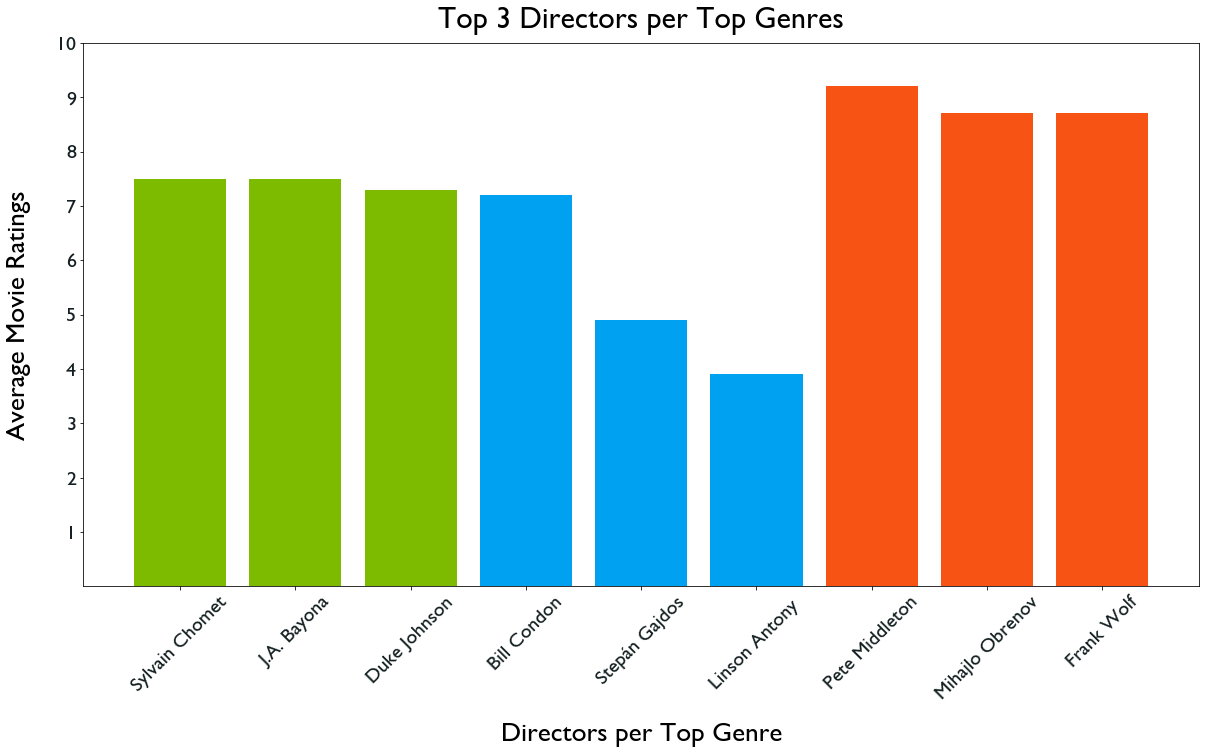

In [154]:
# Create variables for chart
directors_x = ['Sylvain Chomet', 'J.A. Bayona', 'Duke Johnson', 'Bill Condon', 'Stepán Gajdos', 'Linson Antony ', 'Pete Middleton', 'Mihajlo Obrenov', 'Frank Wolf']
directors_y = [7.5, 7.5, 7.3, 7.2, 4.9, 3.9, 9.2, 8.7, 8.7]
y_ticks = [1,2,3,4,5,6,7,8,9,10]
c = ['#7CBB00', '#7CBB00', '#7CBB00', '#00A1F1', '#00A1F1', '#00A1F1', '#F65314', '#F65314', '#F65314']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))

bars = ax.bar(directors_x, directors_y, color=c)
ax.set_xlabel('Directors per Top Genre', fontsize=27, labelpad=20)
ax.set_ylabel('Average Movie Ratings', fontsize=27, labelpad=25)
ax.set_title('Top 3 Directors per Top Genres', fontsize=30, pad=15);
ax.set_ylim(0, 10, 1)
ax.set_yticks(y_ticks);
ax.set_yticklabels(y_ticks, fontsize=20, color='#152022')
ax.set_xticks(directors_x)
ax.set_xticklabels(directors_x, fontsize=20, rotation=45, color='#152022');

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***